# Loading Libraries and Packages

In [9]:
#packages and libraries
import os,sys
from os import listdir
import string
import re
import urllib
import matplotlib.pyplot as plt
import collections
import operator
import pandas as pd
import numpy as np

# Defining MACROS and Environment Variables

In [3]:
#Global Vars and Macros
#_BASE_DIRECTORY = '/Users/007ri/Miniconda2/envs/onedropcs670/Datasets/AoTM'
_BASE_DIRECTORY = '/Users/sidverma/anaconda/Project/AoTM'
_NN = 300
_SPLIT_RATIO = 0.8
dirs = os.listdir(_BASE_DIRECTORY)

filename = 'aotm_list_ids.txt'
currURL = _BASE_DIRECTORY+'/'+filename
response = urllib.urlopen(currURL)
lines = response.readlines()
AOTM_playLists = []
for line in lines:
    AOTM_playLists += line,
print 'Done Loading the AoTM data'
print 'Total Playlist found: ', len(AOTM_playLists)

Done Loading the AoTM data
Total Playlist found:  29164


# This is the pre-processing of AOTM Dataset [..add more later]

In [6]:
#This is the playList class and structure. We will be using this as out playList Object to store and manipulate playlist.
#self._pid : playlist ID
#self._songList : list of tuples of (ArtistID, SongID)
#self._songFreqDict : the frequency table of the songs only in the current playlist
#self._songFreqDictNorm : _songFreqDict in the nomralized form
class playList():
    def __init__(self, inPid, inSongList, inSongDict = {}, inSongNormDict = {}, inTrainList = [], inTestList = []):
        self._pid = inPid # playlist ID
        self._songList = inSongList #list of tuples of (ArtistID, SongID)
        self._songFreqDict = inSongDict
        self._songFreqDictNorm = inSongNormDict
        self._trainList = inTrainList
        self._testList = inTestList
    def __str__(self):
        strObj = 'ID: '+str(self._pid)+'\n'
        for tup in self._songList:
            strObj += str(tup[0]) + ': '
            strObj += str(tup[1]) + '\n'
        return strObj
    def setSongDict(self, inDict):
        self._songFreqDict = inDict
    def setSongDictNorm(self, inNormDict):
        self._songFreqDictNorm = inNormDict
    def setTrainList(self, inTrainList):
        self._trainList = inTrainList
    def setTestList(self, inTestList):
        self._testList = inTestList

##########################################################################################################################
#This is a helper finctions sections. {[rishabh] Please put all your helper functions here for the modularity of the code}
##########################################################################################################################

#genVocab():
#Purpose: to generate the entire vocablulary.
#Input paramas: the input params are the entire dataset which is in the form of list of playList objects.
#Return Value: The return is the set of the unique songs in the entire input data set
def genVocab(inData):
    totalSongsInputSpace = set()
    for pl in inData:
        for tup in pl._songList:
            totalSongsInputSpace.add(tup[1])
    return totalSongsInputSpace

##########################################################################################################################    
#cleanNSerializePlaylist():
#Purpose: to clean, organize and restructure the input playlist which is in string format.
#Input paramas: the input params are the playList in the string format (raw form as read from the aotm dataset).
#Return Value: The return is playList Object of the input playlist
def cleanNSerializePlaylist(inDataEntry):
    ltmp = inDataEntry.split()
    playListID = ltmp[0]
    ltmp.pop(0)
    playListID = re.sub('#', '', playListID)
    n = len(ltmp)
    songList = []
    for i in xrange(0,n-1,2):
        artistid = ltmp[i][:-1]
        songid = ltmp[i+1]
        tup = (artistid,songid)
        songList.append(tup)
    retObj = playList(playListID, songList)
    return retObj

##########################################################################################################################    
#reStructureAOTMDataset():
#Purpose: a wrapper around the cleanNSerializePlaylist() to call it on every playList in the dataset.
#Input paramas: the input params are the entire dataset which is in the form of list of playList as read from the aotm dataset.
#Return Value: The return is list of playList Object.
def reStructureAOTMDataset(inData):
    retVal = []
    allVocab = inData
    for entry in inData:
        retVal.append(cleanNSerializePlaylist(entry))
    return retVal

##########################################################################################################################    
#pidPlObjMapper():
#Purpose: a wrapper around the cleanNSerializePlaylist() to call it on every playList in the dataset.
#Input paramas: the input params is list of playList Object.
#Return Value: The return is a dictionary of pid : playList obj.
def pidPlObjMapper(inData):
    retDict = collections.defaultdict()
    for plObj in inData:
        retDict[plObj._pid] = plObj
    return retDict

##########################################################################################################################    
#AOTM_CleanDataSet :- Contains all playList object of every playlist inthe aotm dataset. Look at the class playList() for details of object structure
#AOTM_All_Songs :- Contains all the songs ever present in the entire aotm dataset
#AOTM_pid_plObj_mapping :- Contains the {pid : playList object} mapping.

AOTM_CleanDataSet = reStructureAOTMDataset(AOTM_playLists)
AOTM_All_Songs = genVocab(AOTM_CleanDataSet)
AOTM_pid_plObj_mapping = pidPlObjMapper(AOTM_CleanDataSet)

print 'Done with processing an parsing the lists. Check stats below: '
print 'Number of Playlists: ', len(AOTM_CleanDataSet)
print 'Total Songs in the AoTM dataset: ', len(AOTM_All_Songs)

Done with processing an parsing the lists. Check stats below: 
Number of Playlists:  29164
Total Songs in the AoTM dataset:  218261


# Exploratory Data Analysis
* Let's look at some of the statistical aspects of our datasets
* We hope to gain some valuable insights which might help our analysis in terms of cleaning the dataset to remove outliers and other spurious features.

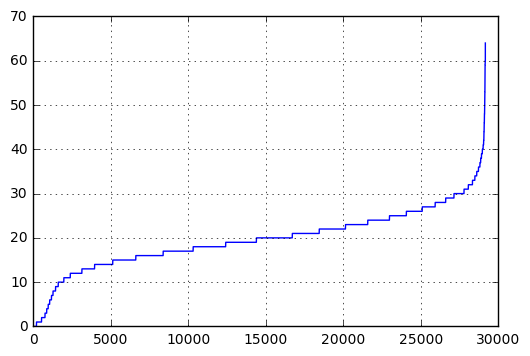

In [8]:
##########################################################################################################################    
#analysisPlaylistSize():
#Purpose: an analysis function to look at the distribution of Playlist Lengths.
#Input paramas: the input params is list of playList Object.
#Return Value: The return is null.

def analysisPlaylistSize(inData):
    X , Y = [], []
    temp = []
    for p in inData:
        temp.append(len(p._songList))
    temp.sort()
    idx = 1
    for t in temp:
        X.append(idx)
        Y.append(t)
        idx += 1
    plt.plot(X, Y)
    plt.grid()
    plt.show()
    return 
analysisPlaylistSize(AOTM_CleanDataSet)

### Key Takeaways:
* As we can see from the above analyses, approx ~ 2000 playlists have a length fewer than 10 songs. Hence it may be difficult to create good recommendations for such user playlists since the vector size is relatively smaller than most of the others in the dataset.
* Thus we propose, to select only those playlists that have a vector length > 10 songs.

# Cleaning Data

In [20]:
##########################################################################################################################    
#removeUnwantedPlaylist():
#Purpose: remove the playLists with less k songs.
#Input paramas: the input params is list of playList Object & k -> thresHold.
#Return Value: list of playList Object with >k songs.
def removeUnwantedPlaylist(inData, k = 10):
    retval = []
    for i in inData:
        if len(i._songList) < 10:
            continue
        retval.append(i)
    return retval

#Clean data
AOTM_CleanDataSet = removeUnwantedPlaylist(AOTM_CleanDataSet, 10)
print "Done removing unwanted playLists, viz pl with <10 songs!"
##########################################################################################################################    
#setTestTrainLists():
#Purpose: a helper to set the plObj._trainList, plObj._testList
#Input paramas: the input params is list of playList Object.
#Return Value: void.
def setTestTrainLists(inData):
    for pl in inData:
        n = len(pl._songList)
        k = int(_SPLIT_RATIO*n)
        trainList = pl._songList[:k]
        testList = pl._songList[k:]
        pl.setTrainList(trainList)
        pl.setTestList(testList)
    return
#invoke fucntion
setTestTrainLists(AOTM_CleanDataSet)
print "Done setting train and test lists!"
##########################################################################################################################    
#setVocabDicts():
#Purpose: a helper to set the plObj.__songFreqDict for each playlist.
#Input paramas: the input params is list of playList Object.
#Return Value: void.
def setVocabDicts(inData):
    for pl in inData:
        plVecDict = collections.defaultdict(int)
        for tup in pl._trainList:
            plVecDict[tup[1]] += 1
        pl.setSongDict(plVecDict)
    return

#invoking the above function call
setVocabDicts(AOTM_CleanDataSet)
print "Done Creating the song freq dicts!"

##########################################################################################################################    
#normalize():
#Purpose: a helper to normalize the plObj._songFreqDict for each playlist.
#Input paramas: the input params is playList._songFreqDict.
#Return Value: the normalized dict of the input playList.
def normalize(inPlaylistDict):
    normSum = 0.0
    retDict = collections.defaultdict()
    for i in inPlaylistDict:
        normSum += inPlaylistDict[i]*inPlaylistDict[i]
    normSum = normSum**0.5
    for i in inPlaylistDict:
        retDict[i] = (1.0*inPlaylistDict[i])/normSum
    return retDict

##########################################################################################################################    
#setNormVocabDicts():
#Purpose: a wrapper to set the plObj._songFreqDictNorm for each playlist.
#Input paramas: the input params is list of playList Object.
#Return Value: void
def setNormVocabDicts(inData):
    for pl in inData:
        SongFreqDictNorm = normalize(pl._songFreqDict)
        pl.setSongDictNorm(SongFreqDictNorm)
    return

#invoking the above function call
setNormVocabDicts(AOTM_CleanDataSet)
print "Done Creating the NORMALIZED song freq dicts!"

Done removing unwanted playLists, viz pl with <10 songs!
Done setting train and test lists!
Done Creating the song freq dicts!
Done Creating the NORMALIZED song freq dicts!


# Cosine Vector Space

In [11]:
##########################################################################################################################    
#getCosineScore():
#Purpose: to calculate the cosine similarity .
#Input paramas: the input params are two playList Objects whose similarity is to be calculated.
#Return Value: cosine similarity measure (float value)
def getCosineScore(inPlaylist, inRefPlayList):
    score = 0.0
    inPlaylistDict = inPlaylist._songFreqDictNorm
    inRefPlayListDict = inRefPlayList._songFreqDictNorm
    for i in inPlaylistDict:
        if i in inRefPlayListDict:
            score += (1.0*inPlaylistDict[i]*inRefPlayListDict[i])
    return score

##########################################################################################################################    
#cosineSimilartiy():
#Purpose: to calculate the cosine similarity .
#Input paramas: the input params is list of playList Object in the entrie input space and the user playlist.
#Return Value: a dict of playList ids as with similarity measure as value.
def cosineSimilartiy(inPlayList, inOtherPlayLists):
    res = collections.defaultdict(float)
    for refPl in inOtherPlayLists:
        if refPl._pid == inPlayList._pid:
            continue
        cosineScore = getCosineScore(inPlayList, refPl)
        res[refPl._pid] = cosineScore
    return res

##########################################################################################################################    
#getKNN():
#Purpose: get k nearest neighbors to inPut playlist.(Distance sim)
#Input paramas: the input params is user playList, list of playList Object and inK which is defaulted to _NN (macro defined at the beginng).
#Return Value: top inK number of playlist IDs as a list.
def getKNN(inPlayList, inOtherPlayLists, bTruncateZeros = False, inK = _NN):#_NN is a macro define above with value 300 or less if we have <300 similars.
    simlarityDict = cosineSimilartiy(inPlayList, inOtherPlayLists)
    sorted_simlarityDict = sorted(simlarityDict.items(), key=operator.itemgetter(1), reverse = True)
    retVal = []
    for kv in sorted_simlarityDict[:inK]:
        if bTruncateZeros and kv[1] <= 0.0:
            return retVal
        retVal += kv[0],
    return retVal

inP = AOTM_CleanDataSet[0]
inO = AOTM_CleanDataSet
tmp = getKNN(inP, inO, True)
print len(tmp)
print "Done!!!!"

0
Done!!!!


# Theory of why not to use aotm dataset and moving on to lastfm

The AotM dataset contained only artists, songs and thus did not have enough features for creating a good recommendation model.
The Cornell dataset contains no playlists, so it is practically of little use to our model (maybe for testing).
The last.fm dataset could be obtained from the API, which apart from the required data, also contained a number of additional features such as user_ids, song tags, listening count, number of times played, timestamp. Thus we selected this dataset for building our recommendation model.

# Include all you Packages and Libs here

In [2]:
#packages and libraries
import os,sys
import string
import re
import urllib
import matplotlib.pyplot as plt
import collections
import operator
import numpy as np
import pandas as pd
import math
import time
import random
from os import listdir

/Users/sidverma/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Include your globar vars and MACROS here


In [3]:
#Put your base directory here
#ADD ALL YOUR FILE NAMES HERE AND USE THESE NAMES IN THE DICT
_BASEDIRECTORY = '/Users/sidverma/Desktop/IR/'
_FILE_MAIN = 'Final.csv'
_FILE_TAG_FREQ_FILE = 'FinalTagFreq.csv'
_FILE_SONG_BOOL_TAGS = 'FinalTagroomMergedVecs.csv'
_FILE_SAMPLE_USERS = 'Best_Users.txt'
_FILE_KNN_BASELINE_USERS = 'knnSimilarity.csv'
_USER_LIST = []

# Dataset: last.fm Crawling and Pre-processing

We are using pylast module to crawl data exposed by Last.fm.  pylast is a Python interface to Last.fm. 

## a) Getting usernames for users
We started by collecting 6000 usernames in their database. We started by one user and added his friends to the user-list. We did this in Breadth First Search Pattern. This was a challenging task considering the network errors in the API calls and amount of time required. We finally used on 3000 users out of 6000 users.
## b) Getting user playlists based on usernames
Next for all the usernames in the user list obtained in the previous step, we found the last 200 songs listened by them. We consider that as a playlist for that user. We collected information like artist name, timestamp, song name, and album name.
## c) Getting song meta-data like social tags
Next we collected social tags for each song fetched in the previous step. We observed that the tag data was skewed based on the the number of tags. So we cleaned the tags later on. The tag information is used in the content-based scoring.
## d) Getting song numerical features like popularity
For each song we also found numerical features like total listeners count and number of times the track was played. This data is used in scoring based on Numerical Features.

# Data analysis and Plots

###  Dataset: last.fm at a Glimpse...
* Features: The last.fm dataset contained the User_IDs, Song Name, Artist, Album, Timestamp, Song's Popular Tag IDs, Popularity Count, User Count. However, there no Songs' numerical metadata such as Song Length, Bit Rate, Year Released etc. Thus we decide to give relatively lower weightage to the Songs' numerical features.
* Data Statistics:
    * ~3000 User Playlists(where each User had a single Playlist)
    * ~200 Songs in a Playlist
    * ~600,000 Songs in the Corpus.
    * ~225,000 Unique Song-Tag IDs (after Stemming and Case-Folding). Upon further analysis, ~40% of the Song Corpus had no tags
    
* Looking at User Playlist Count

###  Some additional Observations
* Since most users have a playlist count >150 Songs, we will focus our attention on such users. Additionally, we can look at users that have a good number of Tags for each Song, as well as a good proportion of such songs in their playlist.

* Looking at Tag Frequency Plot

* Looking at the large dimension of tags in comparison to the Song Corpus, we decide to perfrom dimensionalty reduction on the Tags list and select the top 1000 most frequent tags for each song.

# Observation and decision based on them moving fwrd

### Tags-Frequency Plot.

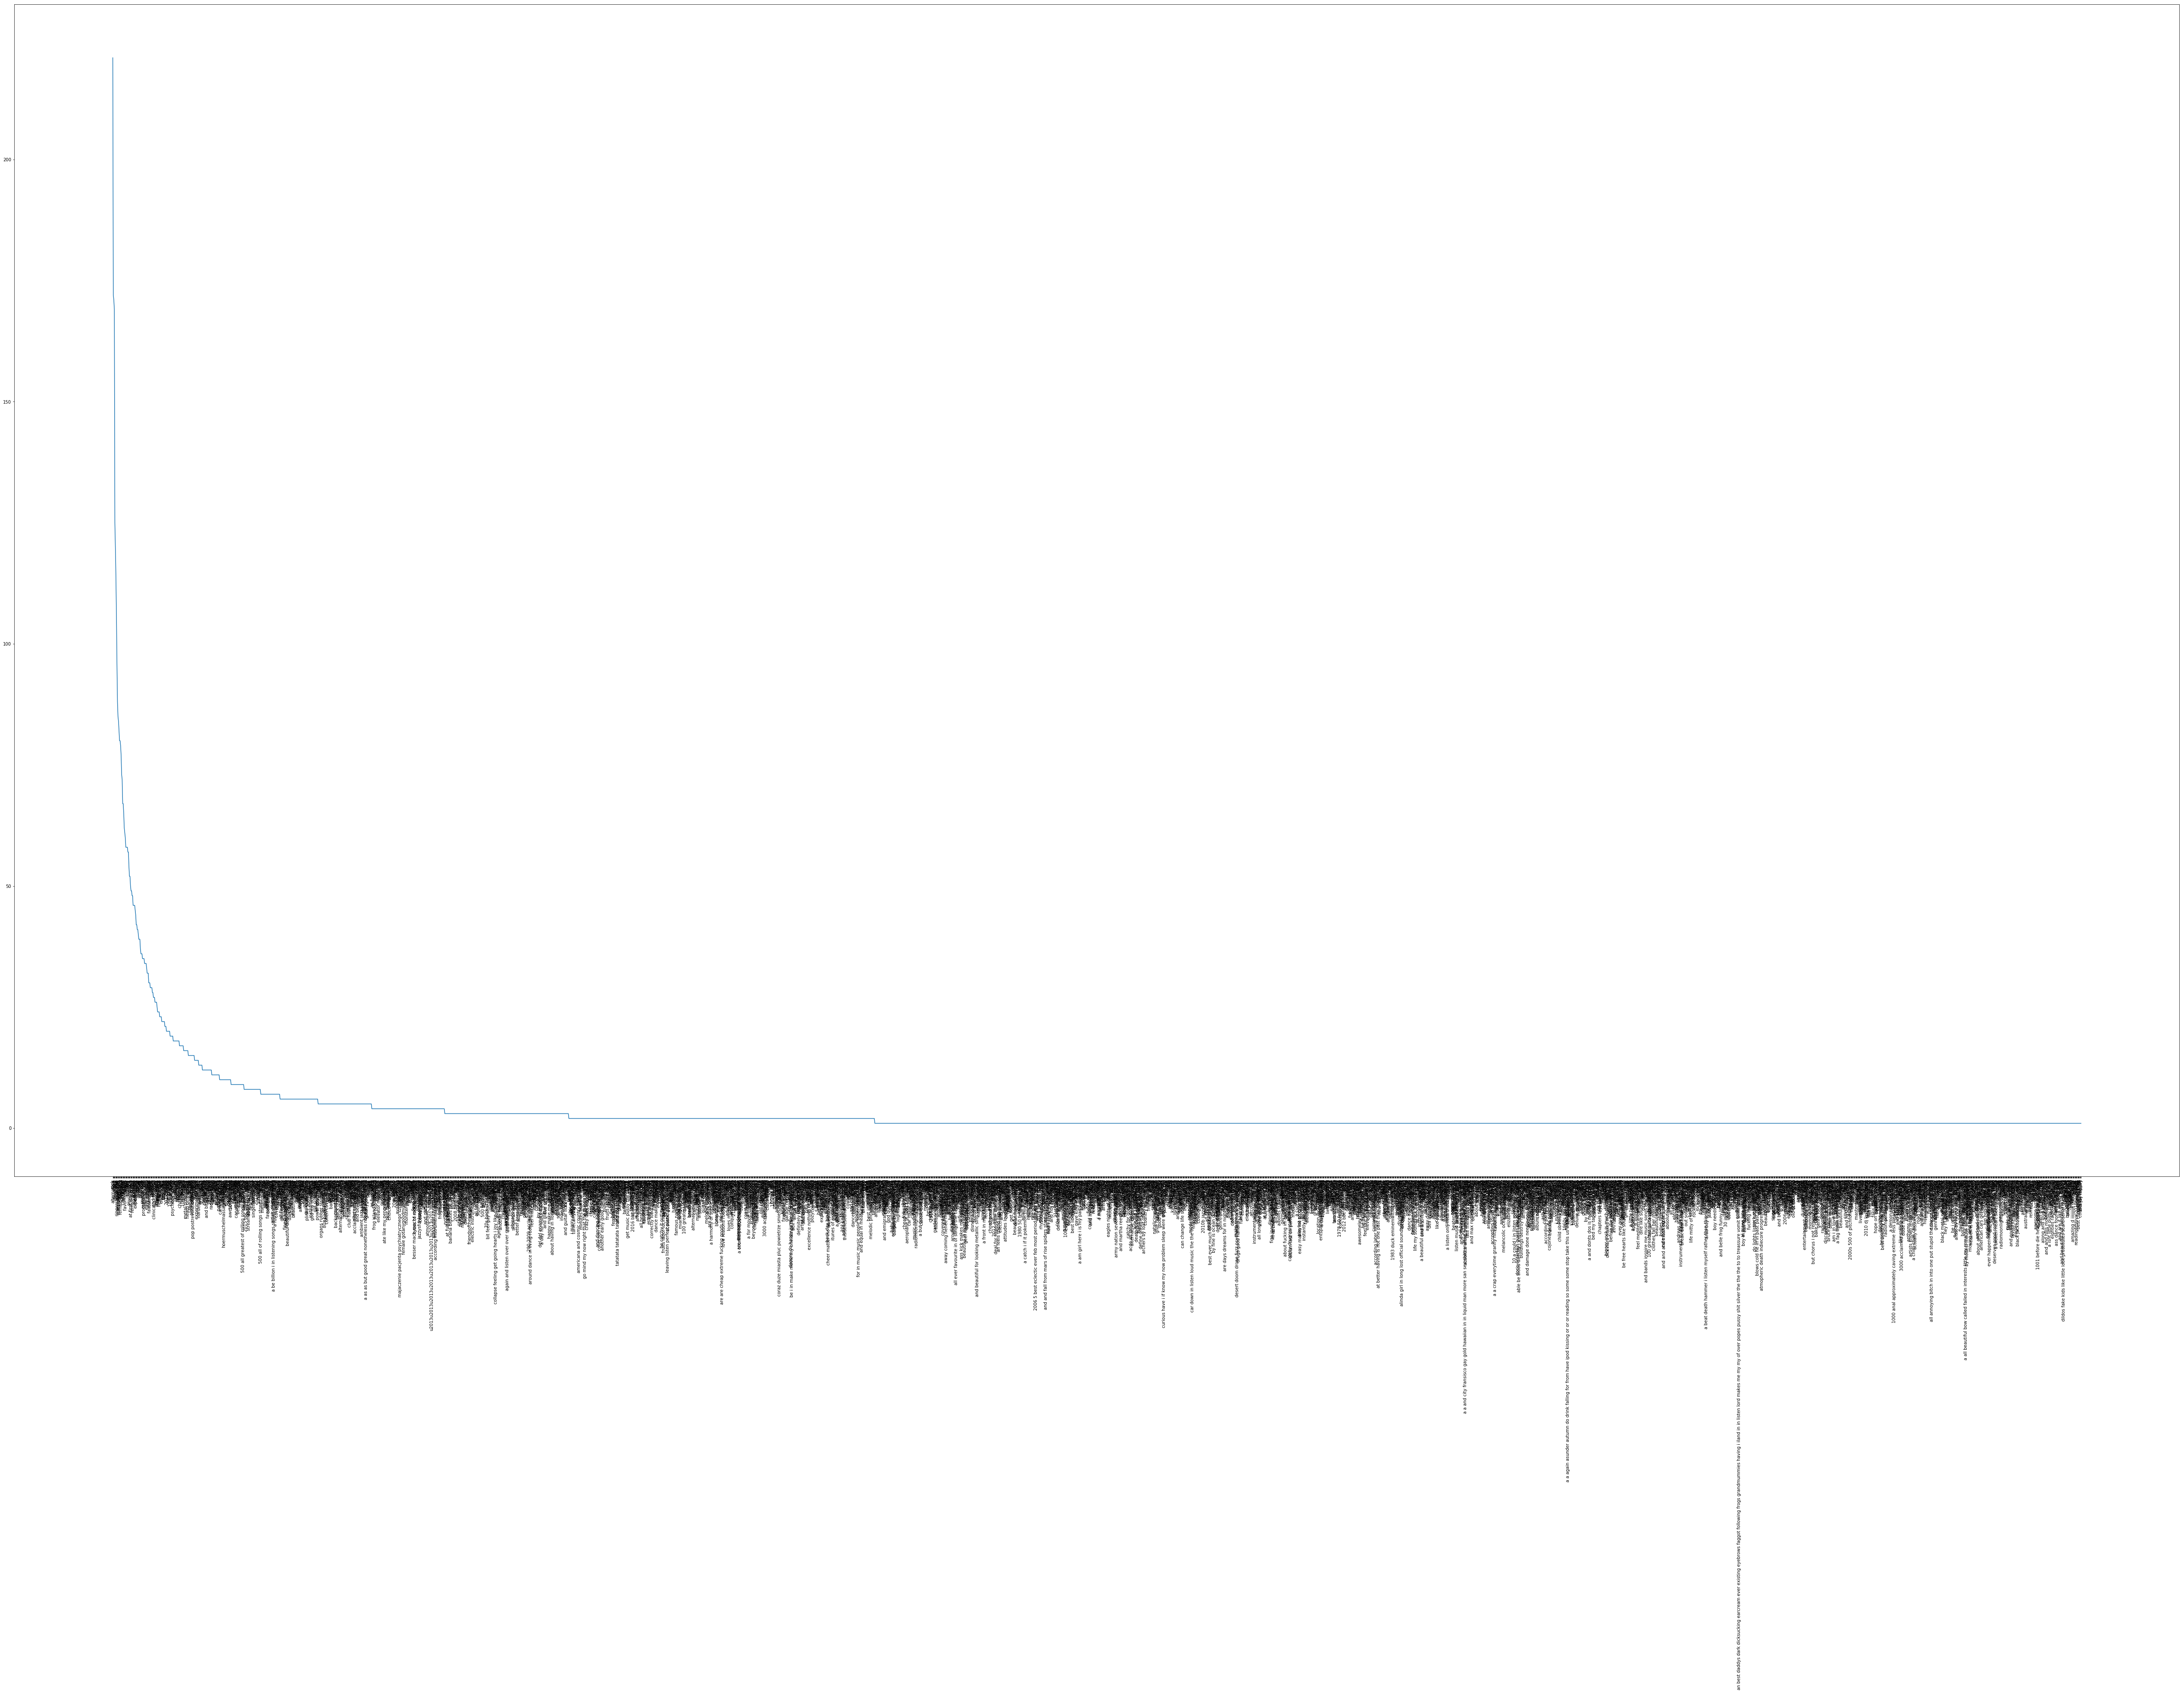

In [15]:
# plt.figure(figsize = (90,50))
# x = xrange(len(freqDict))
# plt.xticks(x, xTicks, rotation=90)
# plt.plot(x,y)
# plt.show()

# Faceted Track Scoring
In this section, we present the details of our multi-faceted
weighted scoring approach. The goal is to determine a relevance score for each possible next track given a playlist history h (sequence of tracks) using different input signals.

In [35]:
##########################################################################################################################    
#getUsers():
#Purpose: A function to get the best set of users from the corpus
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
os.chdir(_BASEDIRECTORY)
def getUsers():
    f = open(_FILE_SAMPLE_USERS, 'r')
    users = []
    for l in f:
        users.append(l[:-1])
    return users
_USER_LIST = getUsers()
print _USER_LIST
print "Done"

['monkeyhacker', 'badboy495', 'sonnycorleones', 'heavydirtysoul_', 'Garry_Drezden']
Done


# 1. Baseline Algorithm

## 1A) Theory

We have used kNN Algorithm as a baseline. Given a history h and a set $N_{h}$ of nearest neighbor playlists of h, we compute the kNN score of a target track $t_{*}$ with $sim_{cosine}(h, n)$ as the binary cosine similarity of track occurrences in $h$ and $n$. $1_{n}(t^{*}) = 1$ if $n$ contains $t^{*}$ and 0 otherwise.

$$score_{kNN}(h, t^{*}) = \sum_{n \epsilon N_{h}} sim_{cosine}(h,n)*1_{n}(t^{*}) $$

This is done in  two steps:  
i.) In first phase we calculate 300 nearest neighbors of the user based on cosine similarity of the user playlist and other users' plalylist. The scores are reported in file _FILE_KNN_BASELINE_USERS_.  
ii.) In the next step, kNN baseline scores are calculated using the equation given above.

## 1B[i]) Phase 1 Code: Getting Nearest Users using KNN300

In [15]:
_SPLIT_RATIO=0.8
_NUM_OF_NEIGHBORS=300

In [ ]:
class kNNGenerator(object):
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: 
#Return Value: 
    def __init__(self):
        self.user_list=[]
        self.song_list=[]
        self.similarities = []
        self.similar_neighbors = []
        self.similarity_scores = []
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: 
#Return Value: 
    def similarity_func(self,playlist1, playlist2):
        set2 = set(playlist2)
        count = [1 for song in playlist1 if song in set2]
        return float(sum(count)) / math.sqrt(len(playlist1) * len(playlist2))
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: 
#Return Value: 
    def getUserSongList(self):
        frame = pd.read_csv(_FILE_MAIN)
        frame.drop(["Playtime", "Album", "Match", "Listeners", "Playcount", "Duration", "Tags"], axis=1, inplace="True")
        grouped = frame.groupby(by="Users")
        user_groups = grouped.groups
        for k in user_groups.keys():
            self.user_list.append(k)
            user_group = grouped.get_group(k)
            self.song_list.append(user_group.Songs.tolist())
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: 
#Return Value: 
    def getSimilarityScores(self):
        len_user_list = len(self.user_list)
        for i, user in enumerate(self.user_list):
            print "Calculating 300NN for User", i
            similarity = []
            end_index = int(math.ceil(_SPLIT_RATIO * len(self.song_list[i])))
            curr_user_playlist = self.song_list[i][:end_index]
            print "User details: ", user, len(curr_user_playlist)
            for j in range(0, i):
                print "Parsing Row: ", j
                similarity.append((self.user_list[j], self.similarity_func(curr_user_playlist, self.song_list[j])))
            for j in range(i + 1, len_user_list):
                print "Parsing Row: ", j
                similarity.append((self.user_list[j], self.similarity_func(curr_user_playlist, self.song_list[j])))
            self.similarities.append(similarity)
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: 
#Return Value: 
    def sortNeighbors(self):
        for i in range(len(self.similarities)):
            self.similarities[i].sort(key=lambda x: float(x[1]), reverse=True)
            self.similarities[i] = self.similarities[i][:_NUM_OF_NEIGHBORS]
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: 
#Return Value: 
    def saveScores(self):
        for similarity in self.similarities:
            curr_similar_neighbors = [similar[0] for similar in similarity]
            curr_similarity_score = [similar[1] for similar in similarity]
            self.similar_neighbors.append(curr_similar_neighbors)
            self.similarity_scores.append(curr_similarity_score)
        df = pd.DataFrame(
            data={"Users": self.user_list, "kNN": self.similar_neighbors, "Similarities": self.similarity_scores},
            columns=["Users", "kNN", "Similarities"])
        df.to_csv(_FILE_KNN_BASELINE_USERS, sep=',')
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: 
#Return Value: 
def generatekNN():
    kNNGeneratorObj= kNNGenerator()
    kNNGeneratorObj.getUserSongList()
    kNNGeneratorObj.getSimilarityScores()
    kNNGeneratorObj.sortNeighbors()
    kNNGeneratorObj.saveScores()
    print "Done"
generatekNN()

## 1B[ii]) Phase 2 Code: Calculating Baseline Score using KNN

In [16]:
##########################################################################################################################    
#getCleanUserList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: Users as String
#Return Value: Users as List of individual username strings
def getCleanUserList(inUsers):
    inUsers = inUsers.replace('\"', '')
    inUsers = inUsers.replace('[', '')
    inUsers = inUsers.replace(']', '')
    inUsers = inUsers.replace('\'', '')
    return inUsers.split(', ')
##########################################################################################################################    
#getCleanScoreList():
#Purpose: A function to remove all unnecessary regex
#Input paramas: Scores as String
#Return Value: Scores as List of floats for each neighbor
def getCleanScoreList(inScore):
    retVal = []
    inScore = inScore.replace('[', '')
    inScore = inScore.replace(']', '')
    tmpList = inScore.split(', ')
    for i in tmpList:
        retVal.append(float(i))
    return retVal
##########################################################################################################################    
#getSongCorpus():
#Purpose: A function to get the best Song Corpus
#Input paramas: List of users who contribute to the corpus
#Return Value: Song Corpus
def getSongCorpus(inUsers):
    os.chdir(_BASEDIRECTORY)
    df = pd.read_csv(_FILE_MAIN)
    groupFrame = df.groupby(by = 'Users')
    corpus = set()
    for usr in inUsers:
        currFrame = groupFrame.get_group(usr)
        songsPool = currFrame.Songs.tolist()
        for s in songsPool:
            corpus.add(s)
    return corpus
##########################################################################################################################    
#calculateSongsInvertedIndex():
#Purpose: A function to calculate the inverted index for song playlist.
#Input paramas: neighbor list, corpus of songs
#Return Value: dict of key->Song, val->list of users that have thi song
def calculateSongsInvertedIndex(inUserList, inCorpus):
    invertedIndexDict = collections.defaultdict(list)
    os.chdir(_BASEDIRECTORY)
    df = pd.read_csv(_FILE_MAIN)
    groupFrame = df.groupby(by='Users')
    for user in inUserList:
        currFrame = groupFrame.get_group(user)
        userSongsList = currFrame.Songs.tolist()
        for s in userSongsList:
            invertedIndexDict[s].append(user)
    return invertedIndexDict
##########################################################################################################################    
#getSongScore():
#Purpose: A function to get the songs score for the current user
#Input paramas: song for which score is to be calculated, (neighbors,knn-score) tuple list, user/playlits in which the song occurs
#Return Value: float score value
def getSongScore(song, inUser, occuringPlayLists, neighbor_scores_tuples_list):
    retVal = 0.0
    for tup in neighbor_scores_tuples_list:
        neighbor = tup[0]
        neighborScore = tup[1]
        if neighbor in occuringPlayLists:
            retVal += neighborScore
    return retVal
##########################################################################################################################    
#calculateSimilarityMeasure():
#Purpose: A function to get the dict of scores for all songs in the corpus for the user
#Input paramas: root user, inverted dict, neighbor score tuple list
#Return Value: scores Dictionary for the root user
def calculateSimilarityMeasure(inUser, inInvertedScoresDict, neighbor_scores_tuples_list):
    scoresDict = collections.defaultdict(float)
    for song in inInvertedScoresDict:
        score = getSongScore(song, inUser, inInvertedScoresDict[song], neighbor_scores_tuples_list)
        scoresDict[song] = score
    return scoresDict
##########################################################################################################################    
#knnSimilarity():
#Purpose: A function to get the baseline Knn estimate
#Input paramas: List of users whose knn baseline is to be calculated
#Return Value: Null (Dumps score files for each input usr)
def knnSimilarity(inUserList):
    os.chdir(_BASEDIRECTORY)
    df = pd.read_csv(_FILE_KNN_BASELINE_USERS)
    userFrame = df.groupby(by='Users')
    index = 0
    userAlreadyVisited = set()
    for i, row in df.iterrows():
        u = row['Users']
        if u not in inUserList:
            continue
        if u in userAlreadyVisited:
            continue
        userAlreadyVisited.add(u)
        neigbors = row['kNN']
        userList = getCleanUserList(neigbors)
        simScores = row['Similarities']
        simScoresList = getCleanScoreList(simScores)
        neighbor_scores_tuples_list = zip(userList, simScoresList)
        print 'Genrating CORPUS'
        currCorpus = getSongCorpus(userList)
        print 'Done CORPUS GENERATION'
        print u, len(currCorpus)
        print '------------------------'
        print 'Calculating INVERTED INDEX'
        invertedScoresDict = calculateSongsInvertedIndex(userList, currCorpus)
        print 'INVERTED INDEX Calculated'
        print '------------------------'
        print 'Calculating SCORES ', u
        similarityScores = calculateSimilarityMeasure(u, invertedScoresDict, neighbor_scores_tuples_list)
        print 'SCORES Calculated ', u
        print '------------------------'
        final_df = pd.DataFrame(similarityScores.items(), columns=['Songs', 'Score'])
        fname = u + 'KNN_Score.csv'
        print "Dumping in File " + fname
        final_df.to_csv(fname)
##########################################################################################################################    
#getUsers():
#Purpose: A function to get the best set of users from the corpus
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def entryPoint():
    userList = getUsers()
    knnSimilarity(_USER_LIST)
    print 'DONE'
    
entryPoint()

Genrating CORPUS
Done CORPUS GENERATION
monkeyhacker 32012
------------
Calculating INVERTED INDEX
INVERTED INDEX Calculated
------------
Calculating SCORES  monkeyhacker
SCORES Calculated  monkeyhacker
------------
Dumping in File monkeyhackerKNN_Score.csv
Genrating CORPUS
Done CORPUS GENERATION
badboy495 31271
------------
Calculating INVERTED INDEX
INVERTED INDEX Calculated
------------
Calculating SCORES  badboy495
SCORES Calculated  badboy495
------------
Dumping in File badboy495KNN_Score.csv
Genrating CORPUS
Done CORPUS GENERATION
sonnycorleones 29795
------------
Calculating INVERTED INDEX
INVERTED INDEX Calculated
------------
Calculating SCORES  sonnycorleones
SCORES Calculated  sonnycorleones
------------
Dumping in File sonnycorleonesKNN_Score.csv
Genrating CORPUS
Done CORPUS GENERATION
heavydirtysoul_ 30103
------------
Calculating INVERTED INDEX
INVERTED INDEX Calculated
------------
Calculating SCORES  heavydirtysoul_
SCORES Calculated  heavydirtysoul_
------------
Dumpi

# Computing Additional Suitability Scores
Playlist creators can have certain “themes”, goals or quality criteria in mind when they design a playlist. The idea of our faceted scoring method is to combine the kNN approach with additional suitability scores. If we, for example, detect that the homogeneity of the popularity of the tracks is most probably a guiding quality criterion, we should give an extra relevance weight to tracks that are similar in populairty to those in the history; if we observe that several tracks in the history were annotated by users with certain tags, we should increase the relevance score of tracks with similar tags. Generally, the combination of different scores shall serve
two purposes: (1) increasing the hit rate as more relevant tracks receive a higher aggregated score and (2) making the playlist continuation more homogeneous, which is often a desirable goal in the Music Information Retrieval literature. In our experiments, we tested the following scores as examples to validate our approach. The selection was based on the availability of track metadata in public sources.

# 2. Content-Based

## 2A) Theory

We retrieved the social tags  that were assigned to tracks by users on Last.fm as they are valuable indicators of what a certain playlist is about. We removed irrelevant tags like “my favorite” or “like it”, retained the 1,000 most frequent tags and computed TF-IDF (Term Frequency/Inverse Document Frequency) vectors for each track. Given a history $h$ consisting of tracks $t_{i}$ . . .  $t_{n}$ with the TF-IDF vectors $t_{1}^{v}$ to $t_{n}^{v}$, we compute the score of target track t^{*} using its TF-IDF vector t^{∗v} as follows. scorecontent(h, t∗) = simcosine
$$score_{content}(h, t^{*}) = sim_{cosine}(\sum_{t_{i}^{v}\epsilon h }\dfrac{t^{v}_{i}}{|h|} , t^{*v})$$

We have tag vectors for all songs in _FILE_SONG_BOOL_TAGS and tag frequencies in _FILE_TAG_FREQ_FILE. Tag Frequencies are used to calculate IDF scores. We caluclate TF-IDF vector for the playlist of a user and then we caluclate content based similarity score for all other users using the equation mentioned above. Finally we pick top 1000 users and maintain their scores.

## 2B) Code

In [36]:
split_ratio_train_test = 0.8
split_ratio_train = 0.2
user_list = []
neighbours_list = []
scores_list = [] 

# reading the main File
frame = pd.read_csv(_FILE_MAIN)
frame.drop(["Playtime", "Album", "Match" , "Listeners", "Playcount", "Duration", "Tags"], axis=1, inplace="True")

# reading the tags related file:
## Songs Based Scoring
frameSong = pd.read_csv(_FILE_SONG_BOOL_TAGS)
frameSong["Songs"] = frame["Songs"]
groupedSongs = frameSong.groupby(by="Songs")
groupsSongs = groupedSongs.groups
full_len = frameSong.shape[0]
### Users based grouping 
groupedUsers = frame.groupby(by="Users")
groupsUsers=groupedUsers.groups

# Using the dict for storing the IDF vector
df_dict = pd.read_csv(_FILE_TAG_FREQ_FILE)
IDF_DICT = [math.log10((full_len/df_dict['Frequency'][i])) for i in xrange(df_dict.shape[0])]

##########################################################################################################################    
#findmagnitude():
#Purpose: A function to get the best set of users from the corpus
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def findmagnitude(input):
    return math.sqrt(sum(input[i]*input[i] for i in range(len(input))))
##########################################################################################################################    
#normalizefunction():
#Purpose: A function to get the best set of users from the corpus
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def normalizefunction(input):
    listmagnitude =  findmagnitude(input)
    if  listmagnitude == 0:
        return  input
    return [ float(input[i])/listmagnitude  for i in range(len(input)) ]
##########################################################################################################################    
#cosinefunction():
#Purpose: A function to get the best set of users from the corpus
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def cosinefunction(input1, input2):
    return sum(input1[i]*input2[i] for i in range(len(input1)))
##########################################################################################################################    
#TF_IDF_generator():
#Purpose: A function to get the best set of users from the corpus
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def TF_IDF_generator(input):
    return_list = []
    for i in xrange(len(input)):
        if input[i]==0:
            val = 0
        else:
            val = (math.log10(input[i])+1)* IDF_DICT[i]
        return_list.append(val)
    return return_list
##########################################################################################################################    
#normalizeByPlaylistLength():
#Purpose: A function to get the best set of users from the corpus
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def normalizeByPlaylistLength(tf_idf_vector, playlist_length):
    normalized_vec=[(value/float(playlist_length)) for value in tf_idf_vector]
    return normalized_vec
##########################################################################################################################    
#Calculate_content_based_score():
#Purpose: To calculate the user content based on the history
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def Calculate_content_based_score(username):
    historyList = []
    user_group = groupedUsers.get_group(username)
    Full_list = user_group.Songs.tolist()
    content_start_index = len(Full_list)- int(math.ceil(split_ratio_train_test*len(Full_list)))
    content_end_index  = content_start_index + int((split_ratio_train)* (math.ceil(split_ratio_train_test*len(Full_list))))
    Train_list = Full_list[content_start_index:content_end_index]
    for tracks in Train_list:
        tags_len = len(groupedSongs.get_group(tracks).Tags)
        tags_list = groupedSongs.get_group(tracks).Tags.tolist()
        historyListString =  str(tags_list[0]).split("$")
        historytempvec = []
        for itr in historyListString:
            historytempvec.append(int(itr))
        historyList.append (historytempvec)
    TF_IDF_vector_list=[]
    for tag_vector in historyList:
        TF_IDF_listvec = TF_IDF_generator(tag_vector)
        TF_IDF_vector_list.append(TF_IDF_listvec)
    TF_IDF_history = [sum(x) for x in zip(*TF_IDF_vector_list)]
    UserList_normalized = normalizeByPlaylistLength(TF_IDF_history,len(Train_list))
    UserList_normalized=normalizefunction(UserList_normalized)
    ScoringDict = collections.defaultdict(list)
    for allusers in groupsUsers.keys():
        if allusers == username:
            continue
        for tracks in groupedUsers.get_group(allusers).Songs.tolist():
            if tracks in ScoringDict:
                continue
            songtempvec = []
            tags_list = groupedSongs.get_group(tracks).Tags.tolist()
            songlistString =  str(tags_list[0]).split("$")
            for  index,itr in enumerate(songlistString):
                  songtempvec.append(int(itr))
            TF_IDF_songvec = TF_IDF_generator(songtempvec)
            song_normalized = normalizefunction(TF_IDF_songvec)
            scoring_val = cosinefunction(UserList_normalized, song_normalized)
            ScoringDict[tracks]= scoring_val
    reversesorteditems = sorted(ScoringDict.items(), key=operator.itemgetter(1), reverse=True)
    count = 0
    similar_neighbors=[]
    similarity_scores=[]
    for  items in reversesorteditems:
        similar_neighbors.append(str(items[0]))
        similarity_scores.append(str(items[1]))                       
        count = count + 1
    #return similarity_scores
    return similar_neighbors, similarity_scores
##########################################################################################################################    
#Calculate_content_based_score():
#Purpose: To calculate the user content based on the history
#Input paramas: Null
#Return Value: List of best users containing 'User_IDs'
def calculate_for_all(userlist):
    for allusers in userlist:
        user_list = []
        user_list.append(allusers)
        #score_list = Calculate_content_based_score(allusers)
        similar_neighbors,similarity_scores =  Calculate_content_based_score(allusers)
        df = pd.DataFrame(data={"Neighbours": similar_neighbors, "Similarities": similarity_scores }, 
                 columns=["Neighbours", "Similarities"])  
        df.to_csv(str(allusers)+"CONTENT_SIM.csv", sep=',')
calculate_for_all(_USER_LIST)
print "Content Based Similarity Scores Computed..."

monkeyhacker
paali
Ruda_01
Chrilu
GinaLily27
SkyggerHela
athosmaniakk
Vulfhart
Gvenasha
Muriloribeiro
OwnKillers
mariusmuscalu
AnnGubina
Secretly_Insane
RomanEfremov
IullyMelo
Knarrenheins
Moyashii
andyduarte123
DiegoMessias
josimar_oliva
WordsOfEvil
SaintxGutxFree
tarciomeixeira
PalaMate
DarkPrince_
robinjfox
Matheusschmier
Lukke93
cosmokatze
rmk-
tcbp
NakiLaulu
ragnargkum
extraordinary__
LeraBez
piggiihf
mehdi_zarei
danieick
setlistfm
itsaibon
mDante
armandins
emlyncorrin
tsuboband
Woaaw
pSi11
kwiecien123
eutavisom
Olexii_Kazakov
nobodaddyo
SilentNidhogg
PaulaXCIII
heavytown
DamnedDee
Facewalker
sidorovakoza
NihilizM-
shah-in
WampyricRites
fredzx
Hanakumu
Amadi-90
markillestoth
SpeakInTounges
GodofDeathMetal
drttuh
subatomicdreams
jay-nox
robertoluna_
nadineooliveira
mlwry
Phrene
Marutsella
Kak_Lee
anthraxfan
BestaanBoosheid
Djevelozz
JenRafa
loox1
maximryu
mokry_pies
deathsgiantworm
Epsuh
oiifjsu
raphaelmg94
missjael
Gosha96
marvelgastado
partyzantka_M
ZZFin
XfnSnow
qczi92
walterpad

# 3. Numerical Features

## 3A) Theory

We have used track’s general popularity. The assumption of our scoring scheme for numerical values
is that if a feature was actually relevant for the selection of tracks, the spread and variance of the values will be low. Given a history $h$ and a feature value $f_{t_{i}}$ for a track $t_{i}$ in the history, we therefore first compute the mean $\mu$ and standard deviation σ of the observed values. If there are too few values available – some might be unknown – or the standard deviation exceeds some threshold δ, the score is 0. Otherwise, given the feature value $f^{*}_{t}$ for a target track
$t^{*}$ we use the value of the probability density function of a Gaussian distribution as a score, where µ and σ are computed based on the value distributions in the history:

$$score_{numfeature}(h, t^{*}) = \dfrac{1}{\sigma_{h}^{\sqrt{2\pi}}}  e^{- \dfrac{(f^{*}_{t}-\mu_{j})^2}{2\sigma^{2}}}$$

## 3B) Code

In [37]:
split_ratio_train_test = 0.8
split_ratio_train = 0.2
frame = pd.read_csv(_FILE_MAIN)
frame.drop(["Playtime", "Album", "Match"], axis=1, inplace="True")

grouped1 = frame.groupby(by="Songs")
groups1 = grouped1.groups

groupedusers =frame.groupby(by="Users")
groupsusers = groupedusers.groups

groupedartist = frame.groupby(by='Artists')
groupsartist = groupedartist.groups

user_list=[]
song_list=[]
listener_count = []
duration_count = []
artist_list = []
SongsList = []
Artist_scoring_ratio = 0.2

neighbours_list = []
scores_list = []

def calculate_numerical_val(num_feature, mean, variance):
    return (1/math.sqrt(2*math.pi* variance))* math.exp(-1*(math.pow((num_feature-mean),2))/(2* variance))

def numerical_feature_based_score(userlist):
    for username in userlist:
        print username
        user_list = []
        user_list.append(username)
        historyList = []
        user_group = groupedusers.get_group(username)
        #print user_group.Songs
        Full_list = user_group.Songs.tolist()
        content_start_index = len(Full_list)- int(math.ceil(split_ratio_train_test*len(Full_list)))
        content_end_index  = content_start_index + int((split_ratio_train)*(math.ceil(split_ratio_train_test*len(Full_list))))
        Train_list = Full_list[content_start_index:content_end_index]
        numlist = []
        songdict = {}
        for itr, row in groupedusers.get_group(username).iterrows():
            if math.isnan(row["Playcount"]):
                numlist.append(0.0)
            else:
                numlist.append(row["Playcount"])
        mean_num = np.mean(numlist)
        var_num = np.cov(numlist)   
        for allusers in groupsusers.keys():
            if allusers == username:
                continue
            for itr1,row1 in groupedusers.get_group(allusers).iterrows():
                if math.isnan(row1["Playcount"]):
                    songdict[row1["Songs"]] = calculate_numerical_val(0.0,mean_num,var_num)
                else:
                    songdict[row1["Songs"]] = calculate_numerical_val(row1["Playcount"],mean_num,var_num)
        reversesorteditems = sorted(songdict.items(), key=operator.itemgetter(1), reverse=True)
        count = 0
        similar_neighbors=[]
        similarity_scores=[]
        for  items in reversesorteditems:
            similar_neighbors.append(str(items[0]))
            similarity_scores.append(str(items[1]))                       
            count = count + 1
        df = pd.DataFrame(data={"Neighbours": similar_neighbors, "Similarities": similarity_scores }, 
                 columns=["Neighbours", "Similarities"])  
        df.to_csv(str(username) + "NUMERICAL_FEATURES.csv", sep=',')
numerical_feature_based_score(_USER_LIST)
print "Numerical Features Scores Computed..."

monkeyhacker
badboy495
sonnycorleones
heavydirtysoul_
Garry_Drezden
Numerical Features Scores Computed...


# 4. Personal Preferences

## 4A) Theory

Personal preferences, e.g., regarding favorite artists, can influence what people add to their playlists. In our experiments we therefore also include an example of a personalized scoring scheme. We base the method on content features- tags. To build a “long-term” content-based profile for user u
with the recent listening history h, we first compute an averaged TF-IDF vector $CP_{h}$ from entire histoory of  u. For a track $t^{*}$ with a corresponding TF-IDF vector $t_{*v}$, the personalized score ($score_{contentpers}$) is then based on a weighted combination of the similarity of $t^{*}$ with the current history $score_{content}(h, t^{*})$ and the similarity of $t_{∗v}$ with the long-term profile $CP_{h}$, i.e.
$$score_{contentpers}(h, t^{*}) = \alpha · score_{content}(h, t^{*}) + (1 − \alpha) · sim_{cosine}(CP_{h}, t^{∗v})$$

## 4B) Code

In [ ]:
split_ratio_train_test = 0.8
split_ratio_train = 0.3
user_list = []
neighbours_list = []
scores_list = [] 
Preference_factor = 0.4

# reading the main File
frame = pd.read_csv(_FILE_MAIN)
frame.drop(["Playtime", "Album", "Match" , "Listeners", "Playcount", "Duration", "Tags"], axis=1, inplace="True")

# reading the tags related file:
## Songs Based Scoring
frameSong = pd.read_csv(_FILE_SONG_BOOL_TAGS)
frameSong["Songs"] = frame["Songs"]
groupedSongs = frameSong.groupby(by="Songs")
groupsSongs = groupedSongs.groups
full_len = frameSong.shape[0]
### Users based grouping 
groupedUsers = frame.groupby(by="Users")
groupsUsers=groupedUsers.groups

# Using the dict for storing the IDF vector
df_dict = pd.read_csv(_FILE_TAG_FREQ_FILE)
IDF_DICT = [math.log10((full_len/df_dict['Frequency'][i])) for i in xrange(df_dict.shape[0])]

def findmagnitude(input):
    return math.sqrt(sum(input[i]*input[i] for i in range(len(input))))

def normalizefunction(input):
    listmagnitude =  findmagnitude(input)
    if  listmagnitude == 0:
        return  input
    return [ float(input[i])/listmagnitude  for i in range(len(input)) ]

def cosinefunction(input1, input2):
    return sum(input1[i]*input2[i] for i in range(len(input1)))

def TF_IDF_generator(input):
    return_list = []
    for i in xrange(len(input)):
        if input[i]==0:
            val = IDF_DICT[i]
        else:
            val = math.log10(input[i]+1)* IDF_DICT[i]
        return_list.append(val)
    return return_list

def normalizeByPlaylistLength(tf_idf_vector, playlist_length):
    normalized_vec=[(value/float(playlist_length)) for value in tf_idf_vector]
    return normalized_vec

# calculating the user content based on the history
def User_preference_based_score(username):
    historyList = []
    historyFullList = []
    user_group = groupedUsers.get_group(username)
    #print user_group.Songs
    Full_list_complete = user_group.Songs.tolist()
    content_start_index = len(Full_list_complete)- int(math.ceil(split_ratio_train_test*len(Full_list_complete)))
    Full_train_list = Full_list_complete[content_start_index:]
    content_end_index  = content_start_index + int((split_ratio_train)* (math.ceil(split_ratio_train_test*len(Full_list_complete))))
    Train_list = Full_list_complete[content_start_index:content_end_index]
    #print Train_list
    for tracks in Train_list:
        tags_len = len(groupedSongs.get_group(tracks).Tags)
        tags_list = groupedSongs.get_group(tracks).Tags.tolist()
        historyListString =  str(tags_list[0]).split("$")
        historytempvec = []
        for itr in historyListString:
            historytempvec.append(int(itr))
        historyList.append (historytempvec)
    for tracks in Full_train_list:
        tags_len = len(groupedSongs.get_group(tracks).Tags)
        tags_list = groupedSongs.get_group(tracks).Tags.tolist()
        historyFullListString =  str(tags_list[0]).split("$")
        historyFulltempvec = []
        for itr in historyFullListString:
            historyFulltempvec.append(int(itr))
        historyFullList.append (historyFulltempvec)
    TF_IDF_vector_list = []
    for tag_vector in historyList:
        TF_IDF_listvec = TF_IDF_generator(tag_vector)
        TF_IDF_vector_list.append(TF_IDF_listvec)

    TF_IDF_history = [sum(x) for x in zip(*TF_IDF_vector_list)]
    UserList_normalized = normalizeByPlaylistLength(TF_IDF_history,len(Train_list))
    UserList_normalized=normalizefunction(UserList_normalized)

    for tag_vector in historyFullList:
        TF_IDF_listvec = TF_IDF_generator(tag_vector)
        TF_IDF_vector_list.append(TF_IDF_listvec)

    TF_IDF_history = [sum(x) for x in zip(*TF_IDF_vector_list)]
    UserFullList_normalized = normalizeByPlaylistLength(TF_IDF_history,len(Train_list))
    UserFullList_normalized=normalizefunction(UserFullList_normalized)
    ScoringDict = collections.defaultdict(list)
    for allusers in groupsUsers.keys():
        print allusers
        if allusers == username:
            continue
        for tracks in groupedUsers.get_group(allusers).Songs.tolist():
            if tracks in ScoringDict:
                continue
            songtempvec = []
            tags_list = groupedSongs.get_group(tracks).Tags.tolist()
            songlistString =  str(tags_list[0]).split("$")
            for  index,itr in enumerate(songlistString):
                songtempvec.append(int(itr))
            TF_IDF_songvec = TF_IDF_generator(songtempvec)
            song_normalized = normalizefunction(TF_IDF_songvec)
            ScoringDict[tracks]= Preference_factor * cosinefunction(UserList_normalized, song_normalized)+ (1- Preference_factor)* cosinefunction(UserFullList_normalized, song_normalized)
    reversesorteditems = sorted(ScoringDict.items(), key=operator.itemgetter(1), reverse=True)
    count = 0
    similar_neighbors=[]
    similarity_scores=[]
    for  items in reversesorteditems:
        if count == 300:
            break
        similar_neighbors.append(str(items[0]))
        similarity_scores.append(str(items[1]))                         
        count = count + 1      
    return similar_neighbors, similarity_scores

def calculate_for_all(userlist):
    for allusers in userlist:
        user_list = []
        user_list.append(allusers)
        print "Printing the length of the users"
        print allusers
        print "Ending the users"
        #score_list = Calculate_content_based_score(allusers)
        similar_neighbors,similarity_scores =  User_preference_based_score(allusers)
        df = pd.DataFrame(data={"Neighbours": similar_neighbors, "Similarities": similarity_scores }, 
                 columns=["Neighbours", "Similarities"]) 
        df.to_csv(str(allusers)+"USER_PREF.csv", sep=',')
calculate_for_all(_USER_LIST)
print "Personal Preferences Scores Computed..."

Printing the length of the users
monkeyhacker
Ending the users
paali
Ruda_01
Chrilu
GinaLily27
SkyggerHela
athosmaniakk
Vulfhart
Gvenasha
Muriloribeiro
OwnKillers
mariusmuscalu
AnnGubina
Secretly_Insane
RomanEfremov
IullyMelo
Knarrenheins
Moyashii
andyduarte123
DiegoMessias
josimar_oliva
WordsOfEvil
SaintxGutxFree
tarciomeixeira
PalaMate
DarkPrince_
robinjfox
Matheusschmier
Lukke93
cosmokatze
rmk-
tcbp
NakiLaulu
ragnargkum
extraordinary__
LeraBez
piggiihf
mehdi_zarei
danieick
setlistfm
itsaibon
mDante
armandins
emlyncorrin
tsuboband
Woaaw
pSi11
kwiecien123
eutavisom
Olexii_Kazakov
nobodaddyo
SilentNidhogg
PaulaXCIII
heavytown
DamnedDee
Facewalker
sidorovakoza
NihilizM-
shah-in
WampyricRites
fredzx
Hanakumu
Amadi-90
markillestoth
SpeakInTounges
GodofDeathMetal
drttuh
subatomicdreams
jay-nox
robertoluna_
nadineooliveira
mlwry
Phrene
Marutsella
Kak_Lee
anthraxfan
BestaanBoosheid
Djevelozz
JenRafa
loox1
maximryu
mokry_pies
deathsgiantworm
Epsuh
oiifjsu
raphaelmg94
missjael
Gosha96
marvelga

# 5. Artists History

## 5A) Theory

We can find playlists that contain tracks of only one single artist. If a history h has only one artist A, we apply an additional heuristic and compute a special artist score (AS) for tracks by A. As  described in the paper, we used a baseline AS value that is generally higher than the combined scores as computed of previous scores. This ensures that the playlist continuation starts with the “right” artist. The tracks of artist A are then sorted according to their popularity, and we use a position-based decay function that assigns a lower AS value to less popular tracks of the artist and apply a minimum popularity threshold. The tracks of the other artists receive the usual combined score.

## 5B) Code

In [ ]:
split_ratio_train_test = 0.8
split_ratio_train = 0.2
frame = pd.read_csv(_FILE_MAIN)
frame.drop(["Playtime", "Album", "Match"], axis=1, inplace="True")

grouped1 = frame.groupby(by="Songs")
groups1 = grouped1.groups

groupedusers =frame.groupby(by="Users")
groupsusers = groupedusers.groups

groupedartist = frame.groupby(by='Artists')
groupsartist = groupedartist.groups

user_list=[]
song_list=[]
listener_count = []
duration_count = []
artist_list = []
SongsList = []
Artist_scoring_ratio = 0.2

neighbours_list = []
scores_list = []

def artist_scoring_based_score(userlist):
    for username in userlist:
        songdict = {}
        artist_list = []
        user_list=[]
        user_list.append(username)
        user_group=groupedusers.get_group(username)
        Full_list = user_group.Artists.tolist()
        content_start_index = len(Full_list)- int(math.ceil(split_ratio_train_test*len(Full_list)))
        content_end_index  = content_start_index + int((split_ratio_train)* (math.ceil(split_ratio_train_test*len(Full_list))))
        Train_list = Full_list[content_start_index:content_end_index]
        artist_list.extend(Full_list)
        artist_dict = collections.Counter(artist_list)
        similar_neighbors=[]
        similarity_scores=[]
        artist_name = max(artist_dict, key=artist_dict.get)
        if artist_dict[artist_name] > Artist_scoring_ratio * len(artist_list):
            for itr, row in groupedartist.get_group(artist_name).iterrows():
                if math.isnan(row["Playcount"]):
                    songdict[row["Songs"]] = 0.0
                else:
                    songdict[row["Songs"]] = row["Playcount"]
            reversesorteditems = sorted(songdict.items(), key=operator.itemgetter(1), reverse=True)
            count = 0

            for  items in reversesorteditems:
                similar_neighbors.append(str(items[0]))
                similarity_scores.append(items[1])
        else:
                similar_neighbors.append("")
                similarity_scores.append("")
        print user_list
        df = pd.DataFrame(data={"Neighbours": similar_neighbors, "Similarities": similarity_scores }, 
                 columns=["Neighbours", "Similarities"])  
        df.to_csv(str(username) + "ARTIST_SCORE.csv", sep=',')
artist_scoring_based_score(_USER_LIST)
print "Artist History Scores Computed..."

# 6. Combining the Scores

## 6A) Theory
Depending on the available data, various combinations of scores of different types can be used. As per the paper, we tested different configurations using a weighted scoring scheme. Given a set of scoring functions S, the score is 

$$score_{overall}(h, t^{*}) = \Sigma_{score_{i}\epsilon S}score_{i}(h, t^{*}) * w_{i}$$ 

where $w_{i}$ is a configurable weight term for each $score_{i}\epsilon S$. The selection of the scores as well as their corresponding weights depend on the goals that should be achieved. We tested different values for the weight of each score and selected the best ones (listed below) with respect to accuracy. The weights are in accordance with the paper.

<table>
<tr><td>Scoring</td><td>Weight</td></tr>
<tr><td>kNN300</td><td>1.0</td></tr>
<tr><td>ART=single-artist heuristic</td><td>4.0</td></tr>
<tr><td>CP=ContentPers.</td><td>0.3, $\alpha$=0.6</td></tr>

</table>

## 6B) Code

# 7. Next track optimiztion

## 7A) Theory

## 7B) Code

In [ ]:
DataSetFile = _FILE_MAIN

frame = pd.read_csv(DataSetFile)
frame.drop(["Playtime", "Album", "Match" , "Listeners", "Playcount", "Duration"], axis=1, inplace="True")

groupedUsers = frame.groupby(by="Users")
groupsUsers=groupedUsers.groups

groupedSongs = frame.groupby(by="Songs")
groupsSongs=groupedSongs.groups

# Input: 20% of User Playlist and Top - K ranked Songs from Song Corpus
def ComputePlaylistTagAvg(username):
        Full_list_len = len(groupedusers.get_group(username).Songs.tolist())
        end_index = Full_list_len - math.ceil(split_ratio_train_test*Full_list_len)
	Sum_Vector = []
	for index, row in groupedusers.get_group(username).iterrows():
                if index == end_index:
                    break:
		for tag_index, tag_value in enumerate(row['Tags']):
			Sum_Vector[tag_index] += tag_value
	for tag_sum_index, tag_sum_value in Sum_Vector:
		Sum_Vector[tag_sum_index] = tag_sum_value/float(DataFrame.shape[0])
	return Sum_Vector


def ComputeSim(user_avg_tag_veg, ranked_song_tag_vec):
	total = 0.0
	for i in xrange(len(user_avg_tag_veg)):
		total += user_avg_tag_veg[i]*ranked_song_tag_vec[i]
	return total / (float(len(user_avg_tag_veg) * len(ranked_song_tag_vec)) ** 0.5)


def GetIntraSimScore(Similarity_dict, Song_Index):
	total = 0.0
	counter = 0.0
	for key, value in Similarity_dict.iteritems():
		if Song_Index in key[0]:
			total += value
			counter += 1.0
	return total/counter


def Next_track_optimization(userlist):
for user in userlist:
    Scoring_files_content = user + "_CONTENT_SIM.csv"
    Scoring_files_numerical = user + "_NUMERICAL_FEATURES.csv"
    Scoring_files_user_pref =  user + "_USER_PREF.csv"

df_1 = pd.read_csv(Scoring_files_content)
df_2 = pd.read_csv(Scoring_files_numerical)
df_3 = pd.read_csv(Scoring_files_user_pref)


# Defining Variables
 for user in userlist:
    user_avg_tag_veg = ComputePlaylistTagAvg(user)
    scoring_dict = {}
    for itr, row in df1.iterrows:
        scoring_dict[row["Neighbours"]] = row["Similarities"]
    for itr, row in df2.iterrows:
        scoring_dict[row["Neighbours"]] += row["Similarities"]
    for itr, row in df3.iterrows:
        scoring_dict[row["Neighbours"]] += row["Similarities"]
    reversesorteditems = sorted(scoring_dict.items(), key=operator.itemgetter(1), reverse=True)
    songs_list=[] 
    tags_list = []
    for itr in reversesorteditems:
        songs_list.append(itr)
        tags_list.append(groupedSongs.get_group(itr).Tags.tolist())
    Ranked_song_df = pd.DataFrame(data={"Songs": songs_list,"Tags": tags_list },
          columns=["Songs", "Tags"])
    Similarity_dict = collections.OrderedDict()
    IntraSimScore_dict = collections.OrderedDict()
    # Getting average tag vector from root user


# Code for Intra-Ranked Song Similarity
    for i1, r1 in Ranked_song_df.iterrows():
	for i2, r2 in Ranked_song_df.iterrows():
		if set(i1, i2) in Similarity_dict.keys() or i1 == i2:
			continue
		Similarity_dict[set(i1, i2)] = ComputeSim(r1['Tags'], r2['Tags'])

# Code for Similar to User Distribution


for index in xrange(Ranked_song_df.shape[0]):
	IntraSimScore_dict[index] = GetIntraSimScore(Ranked_song_df, index)

Next_track_optimization(_USER_LIST)


# Evaluation of Faceted Track Scoring
**Accuracy and MRR**  
Hit Rate: We compare the hidden user playlist and the suggested playlist. 20 percent of the user playlist is hidden. and we suggest 100. Let's say we 10 songs are hidden and there are 5 of the hidden songs in suggested songs then accuracy is 5/10=0.5. We report the average of the accuracy for all the users.

**Diversity and Coherence - Tags**  
Inverse Intra List Similarity (ILS): Intra List Similarity is the sum of the pairwise similarity cosine of TF-IDF vectors of the songs in the suggested songlist by the algorithm. Inverse ILS is the reciprocal of ILS. 
Tags Overlap: This is the Jaccard similarity measure of the set of tags of user playlist and set of tags of suggested playlist.

**Diversity and Coherence - Artist**  
Artists Overlap: This is the Jaccard similarity measure of the set of artists of user playlist and set of artists of suggested playlist.  

**Diversity and Coherence - Numerical Features Method**  
Differences in Distribution (using mean and SD): We can look at how different the distribution of the Numerical features(such as Playlist Count, Listener Count) are for the recent User tracks and the recommended playlist. To do this we can compute the overlapped area between the normalized distribution for both the playlists using the equation

$$\frac{(x-\mu_2)^2}{2\sigma_2^2} - \frac{(x-\mu_1)^2}{2\sigma_1^2} = \log{\frac{\sigma_1}{\sigma_2}}$$

The solution of the above equation can be computed as
$$c =    \frac{\mu _2 \sigma _1^2-\sigma _2 \left(\mu _1 \sigma _2+\sigma _1 \sqrt{\left(\mu _1-\mu _2\right){}^2+2 \left(\sigma _1^2-\sigma _2^2\right) \log \left(\frac{\sigma _1}{\sigma _2}\right)}\right)}{\sigma _1^2-\sigma _2^2}$$

This point is the point of intersection between the two curves. And the area between (overlap) can be calculated as

$$P(X_1>c) + P(X_2<c) = 1 - F_1(c) + F_2(c) = 1-\frac{1}{2} \text{erf}\left(\frac{c-\mu _1}{\sqrt{2} \sigma _1}\right)+\frac{1}{2} \text{erf}\left(\frac{c-\mu _2}{\sqrt{2} \sigma _2}\right)$$

In [ ]:
# reading the main File
frame = pd.read_csv(_FILE_MAIN)
frame.drop(["Playtime", "Album", "Match" , "Playcount", "Duration", "Tags"], axis=1, inplace="True")

# reading the tags related file:
## Songs Based Scoring
frameSong = pd.read_csv(_FILE_SONG_BOOL_TAGS)
frame['TagVector']= frameSong['Tags']
frameSong["Songs"] = frame["Songs"]
groupedSongs = frameSong.groupby(by="Songs")
groupsSongs = groupedSongs.groups
full_len = frameSong.shape[0]
### Users based grouping
groupedUsers = frame.groupby(by="Users")
groupsUsers=groupedUsers.groups
##Song based grouping in Final.csv file
groupedMainSongs=frame.groupby(by='Songs')
groupsOfMainSongs=groupedMainSongs.groups

# Using the dict for storing the IDF vector
df_dict = pd.read_csv(_FILE_TAG_FREQ_FILE)
IDF_DICT = [math.log10((full_len/df_dict['Frequency'][i])) for i in xrange(df_dict.shape[0])]


def findmagnitude(input):
    return math.sqrt(sum(input[i]*input[i] for i in range(len(input))))

def normalizefunction(input):
    listmagnitude =  findmagnitude(input)
    if  listmagnitude == 0:
        return  input
    return [ float(input[i])/listmagnitude  for i in range(len(input)) ]

def cosinefunction(input1, input2):
    return sum(input1[i]*input2[i] for i in range(len(input1)))

def TF_IDF_generator(input):
    return_list = []
    for i in range(len(input)):
        if input[i]==0:
            #val = IDF_DICT[i]
            val=0
        else:
            val = (math.log10(input[i])+1)* IDF_DICT[i]
        return_list.append(val)
    return return_list


def getHit(hiddensongs, predictedPlaylist):
    set_hiddensongs= set(hiddensongs)
    set_predicted_playlist= set(predictedPlaylist)
    hits= set_hiddensongs.intersection(set_predicted_playlist)
    return len(hits)/float(len(set_hiddensongs))

def getMRR(hiddensong, predictedPlaylist):
    if hiddensong in predictedPlaylist:
        return 1/float((predictedPlaylist.index(hiddensong)+1))
    else:
        return 0


def TagBasedInverseILS(predictedPlaylist):
    TF_IDF_list=[]
    for track in predictedPlaylist:
        if track  in groupsSongs:
            tags_list = groupedSongs.get_group(track).Tags.tolist()
            songlistString =  str(tags_list[0]).split("$")
            this_track_tag_vector = [int(value) for value in songlistString]
            TF_IDF_thistrack=TF_IDF_generator(this_track_tag_vector)
            TF_IDF_thistrack=normalizefunction(TF_IDF_thistrack)
            TF_IDF_list.append(TF_IDF_thistrack)
    similarity=0
    for i in range(len(TF_IDF_list)-1):
        for j in range(i+1, len(TF_IDF_list)):
            similarity+= cosinefunction(TF_IDF_list[i], TF_IDF_list[j])
    return 1/similarity


def TagOverLap(userPlayList, predictedPlaylist):
    set_user_list=set()
    set_predicted_list=set()
    for track in userPlayList:
        if track in groupsSongs:
            tags_list = groupedSongs.get_group(track).Tags.tolist()
            set_user_list.update(tags_list)
    for track in predictedPlaylist:
        if track in groupsSongs:
            tags_list = groupedSongs.get_group(track).Tags.tolist()
            set_predicted_list.update(tags_list)
    return float(len(set_user_list.intersection(set_predicted_list)))/float(len( set_user_list.union(set_predicted_list)))


def ArtistOverLap(userPlayList, predictedPlaylist):
    set_user_list=set()
    set_predicted_list=set()
    for track in userPlayList:
        artist= groupedMainSongs.get_group(track).Artists.tolist()
        set_user_list.update(artist[0])
    for track in predictedPlaylist:
        artist= groupedMainSongs.get_group(track).Artists.tolist()
        set_predicted_list.add(artist[0])
    return float(len(set_user_list.intersection(set_predicted_list)))/ len(set_user_list.union(set_predicted_list))


def NumericalFeatureMeanAndSTDDifference(userPlayList, predictedPlaylist):
    user_listenercount=[]
    predplaylist_listenercount=[]

    for track in userPlayList:
        listenercount = groupedMainSongs.get_group(track).Listeners.tolist()
        if  not math.isnan(listenercount[0]):
            user_listenercount.append(int(listenercount[0]))

    for track in predictedPlaylist:
        listenercount = groupedMainSongs.get_group(track).Listeners.tolist()
        if  not math.isnan(listenercount[0]):
            predplaylist_listenercount.append(int(listenercount[0]))

    user_listenercount_list= np.asarray(user_listenercount)
    predplaylist_listenercount_list = np.asarray(predplaylist_listenercount)
    return np.mean(user_listenercount_list)- np.mean(predplaylist_listenercount_list), np.std(user_listenercount_list)- np.std(predplaylist_listenercount_list)


def getPredictedPlaylist():
    predicted_playlist=[]
    recommended_dict = {}
    CONTENT_BASED_SCORE_FILE = _BASEDIRECTORY + "/" + user + "CONTENT_SIM.csv"
    NUMERICAL_FEATURE_FILE = _BASEDIRECTORY + "/" + user + "NUMERICAL_FEATURES.csv"
    ARTIST_SCORE_FILE = _BASEDIRECTORY + "/" + user + "ARTIST_SCORE.csv"
    KNN_SCORE_FILE = _BASEDIRECTORY + "/" + user + "KNN_Score.csv"
    USER_PREF_FILE = _BASEDIRECTORY + "/" + user + "USER_PREF.csv"

    contentframe = pd.read_csv(CONTENT_BASED_SCORE_FILE)
    numerical_feature_frame = pd.read_csv(NUMERICAL_FEATURE_FILE)
    artists_score_frame = pd.read_csv(ARTIST_SCORE_FILE)
    knn_score_frame = pd.read_csv(KNN_SCORE_FILE)
    user_pref_frame = pd.read_csv(USER_PREF_FILE)

    content_neighbors = contentframe.Neighbours.tolist()
    content_scores = contentframe.Similarities.tolist()

    userpref_neighbors = user_pref_frame.Neighbours.tolist()
    userpref_scores = user_pref_frame.Similarities.tolist()

    knn_neighbors = knn_score_frame.Songs.tolist()
    knn_scores = knn_score_frame.Score.tolist()

    artist_neighbors = artists_score_frame.Neighbours.tolist()
    artist_scores = artists_score_frame.Similarities.tolist()

    numerical_neigbors = numerical_feature_frame.Neighbours.tolist()
    numerical_scores = numerical_feature_frame.Similarities.tolist()

    # print "Adding content based score"
    for neighbor, score in zip(content_neighbors, content_scores):
        recommended_dict[neighbor] = recommended_dict.get(neighbor, 0.0) + content_weight * score

    # print "Adding user preference score"
    for neighbor, score in zip(userpref_neighbors, userpref_scores):
        recommended_dict[neighbor] = recommended_dict.get(neighbor, 0.0) + userpref_weight * score

    # print "Adding user knn score"
    for neighbor, score in zip(knn_neighbors, knn_scores):
        recommended_dict[neighbor] = recommended_dict.get(neighbor, 0.0) + knn_weight * score

    # print "Adding user artist-based score"
    for neighbor, score in zip(artist_neighbors, artist_scores):
        recommended_dict[neighbor] = recommended_dict.get(neighbor, 0.0) + artist_weight * score

    # print "Adding numerical feature score"
    for neighbor, score in zip(numerical_neigbors, numerical_scores):
        recommended_dict[neighbor] = recommended_dict.get(neighbor, 0.0) + numerical_weight * score

    reversesorteditems = sorted(recommended_dict.items(), key=operator.itemgetter(1), reverse=True)
    count = 0
    for item in reversesorteditems:
        if count == 200:
            break
        predicted_playlist.append(str(item[0]))
        count = count + 1

    predicted_playlist = predicted_playlist[1:]
    return predicted_playlist


_BASEDIRECTORY="../data"

best_users=["badboy495", "heavydirtysoul_", "monkeyhacker", "sonnycorleones","Garry_Drezden" ]
accuracy_list=[]
Tag_ILS=[]
Tag_overlap=[]
Numerical_mean=[]
Numerical_SD=[]
Artist_Overlap=[]
content_weight = 0.3
userpref_weight = 0.3
knn_weight = 1.0
artist_weight = 4.0
numerical_weight = 0.5

for user in best_users:
    print "*******************************************************************************************************************************"
    print "Evaluation for user", user
    group_user= groupedUsers.get_group(user)
    full_playlist=group_user.Songs.tolist()
    part_index = int(math.ceil(len(full_playlist)*split_ratio))
    test_playlist=full_playlist[:part_index]
    hidden_playlist= full_playlist[part_index:]
    predicted_playlist= getPredictedPlaylist()
    accuracy=getHit(hidden_playlist, predicted_playlist)
    inverseILS=TagBasedInverseILS(predicted_playlist)
    tag_overlap= TagOverLap(test_playlist,predicted_playlist )
    artist_overlap=  ArtistOverLap(test_playlist,predicted_playlist)
    mean_diff, SD_diff=NumericalFeatureMeanAndSTDDifference(test_playlist, predicted_playlist)
    print "Accuracy", accuracy
    print "inverse ILS", inverseILS
    print "tag overlap",tag_overlap
    print "artist overlap",artist_overlap
    print "numerical mean and SD", mean_diff, SD_diff
    accuracy_list.append(accuracy)
    Tag_ILS.append(inverseILS)
    Tag_overlap.append(tag_overlap)
    Numerical_mean.append(mean_diff)
    Numerical_SD.append(SD_diff)
    Artist_Overlap.append(artist_overlap)

print "*******************************************************************************************************************************"
print "Final Scores"
print  "content_weight = " , content_weight,    "userpref_weight =" ,userpref_weight,    "knn_weight = ",knn_weight,    "artist_weight =" ,artist_weight,    "numerical_weight" ,numerical_weight
print "Accuracy List",  accuracy_list
print "Tag based Inverse ILS", Tag_ILS
print "Tag_overlap" ,  Tag_overlap
print "Numerical_mean_diff", Numerical_mean
print "Numerical_SD", Numerical_SD
print "Artist_Overlap", Artist_Overlap



*******************************************************************************************************************************
Evaluation for user badboy495
Accuracy 0.0512820512821
inverse ILS 9.74604582884e-05
tag overlap 0.0702541106129
artist overlap 0.0
numerical mean and SD 95810.1173681 -113489.892338
*******************************************************************************************************************************
Evaluation for user heavydirtysoul_
Accuracy 0.0769230769231
inverse ILS 0.000460466949522
tag overlap 0.19259882254
artist overlap 0.0
numerical mean and SD -27971.5907305 -119445.540658
*******************************************************************************************************************************
Evaluation for user monkeyhacker
Accuracy 0.375
inverse ILS 0.000330006015262
tag overlap 0.214548802947
artist overlap 0.0
numerical mean and SD -116982.774175 -132894.796981
*******************************************************************************************************************************
Evaluation for user sonnycorleones
Accuracy 0.225
inverse ILS 0.000370427225267
tag overlap 0.139981701738
artist overlap 0.0
numerical mean and SD -108968.805324 -133038.250319
*******************************************************************************************************************************
Evaluation for user Garry_Drezden
Accuracy 0.6
inverse ILS 0.000172983093438
tag overlap 0.109567901235
artist overlap 0.0
numerical mean and SD 90233.8352983 -11300.1771826
*******************************************************************************************************************************
Final Scores
content_weight =  0.3 userpref_weight = 0.3 knn_weight =  1.0 artist_weight = 4.0 numerical_weight 0.5
Accuracy List [0.05128205128205128, 0.07692307692307693, 0.375, 0.225, 0.6]
Tag based Inverse ILS [9.746045828836759e-05, 0.00046046694952211624, 0.0003300060152615796, 0.00037042722526744434, 0.00017298309343776643]
Tag_overlap [0.07025411061285501, 0.19259882253994953, 0.214548802946593, 0.13998170173833485, 0.1095679012345679]
Numerical_mean_diff [95810.117368090432, -27971.59073045128, -116982.77417512692, -108968.80532408881, 90233.8352982863]
Numerical_SD [-113489.89233817148, -119445.54065770307, -132894.796981438, -133038.2503186962, -11300.177182629734]
Artist_Overlap [0.0, 0.0, 0.0, 0.0, 0.0]
